<a href="https://colab.research.google.com/github/Arush0113/ArushTensorflowRepo/blob/main/Customising%20your%20models%20with%20Tensorflow%202/Coding_Tutorials_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Model subclassing and custom training loops

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [51]:
# Build the model

class MyModel(Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dropout = Dropout(0.4)

  def call(self, inputs, training = True):
    x = self.dense_1(inputs)
    if training:
      x = self.dropout(x)
    return self.dense_2(x)

In [52]:
# Print the model summary
model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  704       
_________________________________________________________________
dense_6 (Dense)              multiple                  650       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Build the model

class MyModel(Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dense_3 = Dense(5)
    self.softmax = Softmax()

  def call(self, inputs,):
    x = self.dense_1(inputs)
    y1 = self.dense_2(inputs)
    y2 = self.dense_3(y1)
    concat = concatenate([x,y2])
    
    return self.softmax(concat)

In [54]:
# Print the model summary
model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  704       
_________________________________________________________________
dense_8 (Dense)              multiple                  110       
_________________________________________________________________
dense_9 (Dense)              multiple                  55        
_________________________________________________________________
softmax_2 (Softmax)          multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [87]:
# Create a custom layer

class MyLayer(Layer):

  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3,5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor(
[[-0.06943703  0.06669079 -0.17230874]
 [-0.03467695  0.07580611 -0.18393208]
 [-0.07647724  0.08579997 -0.16436075]
 [-0.01921696  0.08406146 -0.13222769]
 [-0.05876692 -0.00539492 -0.10743168]], shape=(5, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.04210454,  0.06191711, -0.03210635],
       [ 0.00238939,  0.06195689, -0.09499218],
       [-0.05285186, -0.04082963, -0.08217468],
       [-0.06695555, -0.00339337, -0.01477633],
       [ 0.05295002, -0.04072594,  0.05795218]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.04707357,  0.02776573, -0.00621137],
       [-0.0123135 ,  0.03688106, -0.0178347 ],
       [-0.05411379,  0.04687491,  0.00173663],
       [ 0.00314649,  0.0451364 ,  0.03386969],
       [-0.03640347, -0.04431998,  0.05866569]], dtype=float32)>]


In [88]:
# Specify trainable weights

class MyLayer(Layer):

  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal',
                             trainable = False)
    self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros',
                             trainable = False)
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3,5)

In [89]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [90]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):

  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                      trainable = False)
    self.number_call = tf.Variable(initial_value=0,
                                   trainable = False)
    
  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.sum_activation.assign_add(tf.reduce_sum(activations, axis = 0))
    self.number_call.assign_add(inputs.shape[0])
    return activations, self.sum_activation/tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3,5)


In [91]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.18036649 -1.2825412  -0.00915272]
[-0.18036649 -1.2825412  -0.00915272]


In [92]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)

#### Implement the custom layers into a model

In [93]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass

        x = self.layer_1(inputs)
        x=  tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x=  tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [94]:
  # Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02141337 0.00517599 0.01843137 0.02801936 0.01636618 0.01932723
  0.00941794 0.01705426 0.0317383  0.02208736 0.01488989 0.03208938
  0.02857926 0.02929221 0.01046696 0.00880532 0.01068847 0.03722416
  0.0218576  0.0069334  0.03242623 0.02692416 0.00451995 0.01956953
  0.02867604 0.02001929 0.00520878 0.00796657 0.03502599 0.00670761
  0.01057615 0.03584002 0.01850063 0.00671961 0.01261562 0.02394462
  0.01881378 0.04906602 0.05079688 0.07226079 0.01027133 0.04443101
  0.0033825  0.0261287  0.01156616 0.02818411]], shape=(1, 46), dtype=float32)
Model: "my_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_12 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_4 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_13 (MyLay

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [95]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

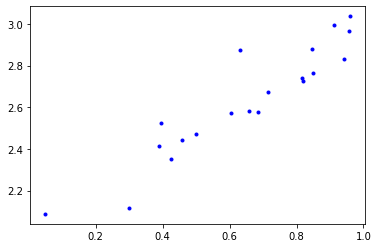

In [96]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [97]:
from tensorflow.keras.layers import Layer

In [98]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(
        shape = (1,),
        initializer = 'random_normal',
    )
    self.b = self.add_weight(
        shape = (1,),
        initializer = 'zeros'
    )

  def call(self, inputs):
    return self.m * inputs + self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.00262396 0.00240553 0.00182627 0.0015534  0.00338618 0.00382298
 0.00363204 0.00327051 0.00169631 0.00375314 0.00273156 0.00337227
 0.00157855 0.00284328 0.00381082 0.00251736 0.00119584 0.00199243
 0.00325853 0.00019704], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.00398529], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [99]:
print(np.random.randn(5,))
print(np.random.randn(5,1))
print(np.random.randn(1,5))

[-0.14168079 -0.26457106  0.91878852 -0.77658986 -0.770842  ]
[[-0.48499173]
 [ 0.32532766]
 [-1.0262912 ]
 [-0.05878749]
 [-1.1072325 ]]
[[ 1.17220288 -2.33934624  1.26386042  2.38317222  0.60423803]]


#### Define the loss function

In [100]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.9796205


#### Train and plot the model

In [101]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 31

for i in range(steps):

  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[1])

  print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 6.979620
Step 1, Loss 5.123182
Step 2, Loss 3.761407
Step 3, Loss 2.762486
Step 4, Loss 2.029733
Step 5, Loss 1.492224
Step 6, Loss 1.097933
Step 7, Loss 0.808698
Step 8, Loss 0.596526
Step 9, Loss 0.440883
Step 10, Loss 0.326705
Step 11, Loss 0.242944
Step 12, Loss 0.181495
Step 13, Loss 0.136413
Step 14, Loss 0.103336
Step 15, Loss 0.079066
Step 16, Loss 0.061256
Step 17, Loss 0.048184
Step 18, Loss 0.038589
Step 19, Loss 0.031544
Step 20, Loss 0.026369
Step 21, Loss 0.022567
Step 22, Loss 0.019771
Step 23, Loss 0.017713
Step 24, Loss 0.016197
Step 25, Loss 0.015079
Step 26, Loss 0.014252
Step 27, Loss 0.013639
Step 28, Loss 0.013183
Step 29, Loss 0.012843
Step 30, Loss 0.012586


m:1,  trained m:[1.1955421]
b:2,  trained b:[1.8319504]


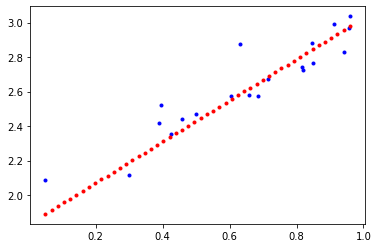

In [102]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [86]:
# Define the custom layers and model

class MyLayer(Layer):

  def __init__(self, units):
    super(MyLayer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(
        shape = (input_dim, self.units),
        initializer = 'random_Normal',
        name = 'kernel',
    )
    self.b = self.add_weight(
        shape = (self.units,),
        initializer = 'zeros',
        name = 'bias',
    )

    def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b


class MyDropout(Layer):

  def __init__(self, rate):
    super(MyDropout, self).__init__()
    self.rate = rate

  def call(self, inputs):
    return tf.nn.dropout(inputs, self.rate)


class MyModel(Model):
  def __init__(self, units_1, units_2, units_3):
    super(MyModel, self).__init__()

    self.layer_1 = MyLayer(units_1)
    self.dropout_1 = MyDropout(0.5)
    self.layer_2 = MyLayer(units_2)
    self.dropout_2 = MyDropout(0.5)
    self.layer_3 = MyLayer(units_3)
    self.softmax = Softmax()

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = tf.nn.relu(x)
    x = self.dropout_1(x)
    x = self.layer_2(x)
    x = tf.nn.relu(x)
    x = self.dropout_2(x)
    x = self.layer_3(x)
    return self.softmax(x)


model = MyModel(64,64,46)
# model.summary()

#### Load the reuters dataset and define the class_names 

In [87]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [88]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [89]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [90]:
# Print the first data example sentence

text_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preprocess the data

In [91]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
x_train[0]

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


array([0., 1., 1., ..., 0., 0., 0.])

In [92]:
# output = np.zeros((len(sample_data), 10000))
# sample_data = train_data[:20]
# # print(output)
# for i, word in enumerate(sample_data):
#   # print(word)
#   output[i, word] = 1
# output.shape

#### Define the loss function and optimizer



In [93]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [94]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [95]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensors((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

n_epochs = 10
weight_decay = 0.005

for epoch in range(n_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg(loss_value)
    epoch_accuracy(to_categorical(y), model(x))

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss {:.3f}: Accuracy {:.3%}".format(
      epoch,
      epoch_loss_avg.result(),
      epoch_accuracy.result()
  ))
    
print("Duration :{:.3f}".format(time.time() - start_time))

NameError: ignored

#### Evaluate the model

In [83]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [84]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [85]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

NameError: ignored

#### Plot the learning curves

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model



#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator



#### Train the model

In [ ]:
# Re-run the training loop



#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

